In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from datetime import datetime as dt

In [2]:
years = [i.name for i in os.scandir(f"inmet-data") if i.is_dir()]
location = "A801"

filenames = []
for year in years[1:]:
    filenames.extend(
        [
            f"{year}/{file.name}"
            for file in os.scandir(f"inmet-data/{year}")
            if location in file.name
        ]
    )

filenames.sort()

dfs = []
for f in filenames:
    df = pd.read_csv(f"inmet-data/{f}", delimiter=";", header=8, encoding="iso-8859-1")
    dfs.append(
        df.rename(
            columns={
                "HORA (UTC)": "Hora UTC",
                "DATA (YYYY-MM-DD)": "Data",
                "RADIACAO GLOBAL (Kj/m²)": "RADIACAO GLOBAL (KJ/m²)",
            }
        )
    )

raw_data = pd.concat(dfs).reset_index()
raw_data

,index,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,0,2000-09-22,00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
1,1,2000-09-22,01:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
2,2,2000-09-22,02:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
3,3,2000-09-22,03:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
4,4,2000-09-22,04:00,0,"1013,9","1014,2","1013,2",-9999,"15,5","14,6",...,"15,5","14,8","14,6",95.0,94.0,94.0,231.0,"4,4","1,2",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200371,5107,2024/07/31,1900 UTC,0,"1014,8","1014,9","1014,8","1501,3","22,5","12,2",...,"22,4",13,"11,1",54.0,46.0,52.0,79.0,"3,4","1,2",NaN
200372,5108,2024/07/31,2000 UTC,0,"1014,2","1014,8","1014,2",642,"21,5","11,9",...,"21,5","12,8","11,4",56.0,49.0,54.0,92.0,"3,6","1,1",NaN
200373,5109,2024/07/31,2100 UTC,0,"1014,4","1014,4","1014,2","50,8","18,9","12,5",...,"18,9","12,5","11,7",66.0,54.0,66.0,129.0,"3,1","1,1",NaN
200374,5110,2024/07/31,2200 UTC,0,"1014,7","1014,7","1014,4",NaN,"17,8","13,5",...,"17,7","13,5","12,5",76.0,66.0,76.0,111.0,"3,2",1,NaN


In [3]:
cols = raw_data.columns

# treating hour data bc it's not super consistent
raw_data[cols[2]] = raw_data[cols[2]].apply(
    lambda s: ":".join([s[:2], s[2:4]]) if isinstance(s, str) and "UTC" in s else s
)
# same for dates
raw_data[cols[1]] = raw_data[cols[1]].apply(
    lambda s: s.replace("/", "-") if isinstance(s, str) else s
)


raw_data["datetime"] = pd.to_datetime(
    raw_data[cols[1]] + " " + raw_data[cols[2]], format="%Y-%m-%d %H:%M"
)


def parseToFloat(col):
    return (
        raw_data[col]
        .apply(lambda x: np.float64(x.replace(",", ".")) if (isinstance(x, str)) else x)
        .apply(lambda x: np.nan if x == -9999.0 else x)
    )


# global-radiation
raw_data["global-radiation"] = parseToFloat(cols[7])

# precipitation
raw_data["total-precipitation"] = parseToFloat(cols[3])

raw_data["relative-humidity"] = parseToFloat("UMIDADE RELATIVA DO AR, HORARIA (%)")

# temperature
raw_data["temperature-last-hour-max"] = parseToFloat(
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"
)
raw_data["temperature-last-hour-min"] = parseToFloat(
    "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"
)

# wind
raw_data["wind-speed"] = parseToFloat("VENTO, VELOCIDADE HORARIA (m/s)")
raw_data["wind-speed-max-gust"] = parseToFloat("VENTO, RAJADA MAXIMA (m/s)")

raw_data
# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.drop(columns=cols[:21]).set_index("datetime")
renamed_data["datetime"] = renamed_data.index
renamed_data

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,datetime
datetime,,,,,,,,
2000-09-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 00:00:00
2000-09-22 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 01:00:00
2000-09-22 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 02:00:00
2000-09-22 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 03:00:00
2000-09-22 04:00:00,NaN,0.0,94.0,15.6,15.5,1.2,4.4,2000-09-22 04:00:00
...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,1501.3,0.0,52.0,23.7,22.4,1.2,3.4,2024-07-31 19:00:00
2024-07-31 20:00:00,642.0,0.0,54.0,22.6,21.5,1.1,3.6,2024-07-31 20:00:00
2024-07-31 21:00:00,50.8,0.0,66.0,21.5,18.9,1.1,3.1,2024-07-31 21:00:00


In [4]:
col = "global-radiation"
idx = "datetime"

df = renamed_data

by_day = (
    renamed_data.groupby([df.index.year, df.index.day_of_year])
    .mean()
    .set_index("datetime")
)

by_day = by_day.loc[by_day["global-radiation"].notna()]
by_day

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2000-09-22 11:30:00,1709.000000,0.000000,69.150000,17.645000,16.665000,1.830000,4.950000
2000-09-23 11:30:00,1621.166667,1.166667,76.125000,18.170833,16.875000,1.558333,4.529167
2000-09-24 11:30:00,519.857143,0.991667,80.750000,15.516667,14.641667,2.454167,7.358333
2000-09-25 11:30:00,1821.769231,0.000000,61.458333,11.275000,10.229167,2.733333,7.195833
2000-09-26 11:30:00,1838.307692,0.000000,63.458333,12.283333,11.295833,1.750000,4.679167
...,...,...,...,...,...,...,...
2024-07-27 11:30:00,571.772727,0.025000,90.583333,17.170833,16.529167,0.820833,2.675000
2024-07-28 11:30:00,166.763636,0.200000,94.875000,15.708333,15.366667,1.233333,4.470833
2024-07-29 11:30:00,294.172727,0.783333,88.708333,12.475000,11.945833,1.620833,6.629167


In [5]:
target = "global-radiation"

features = []
for col in by_day.columns:
    if col == target:
        continue
    if abs(by_day.corr()[target][col]) > 0.4:
        features.append(col)

target, features

('global-radiation',
 ['total-precipitation',
  'relative-humidity',
  'temperature-last-hour-max',
  'temperature-last-hour-min'])

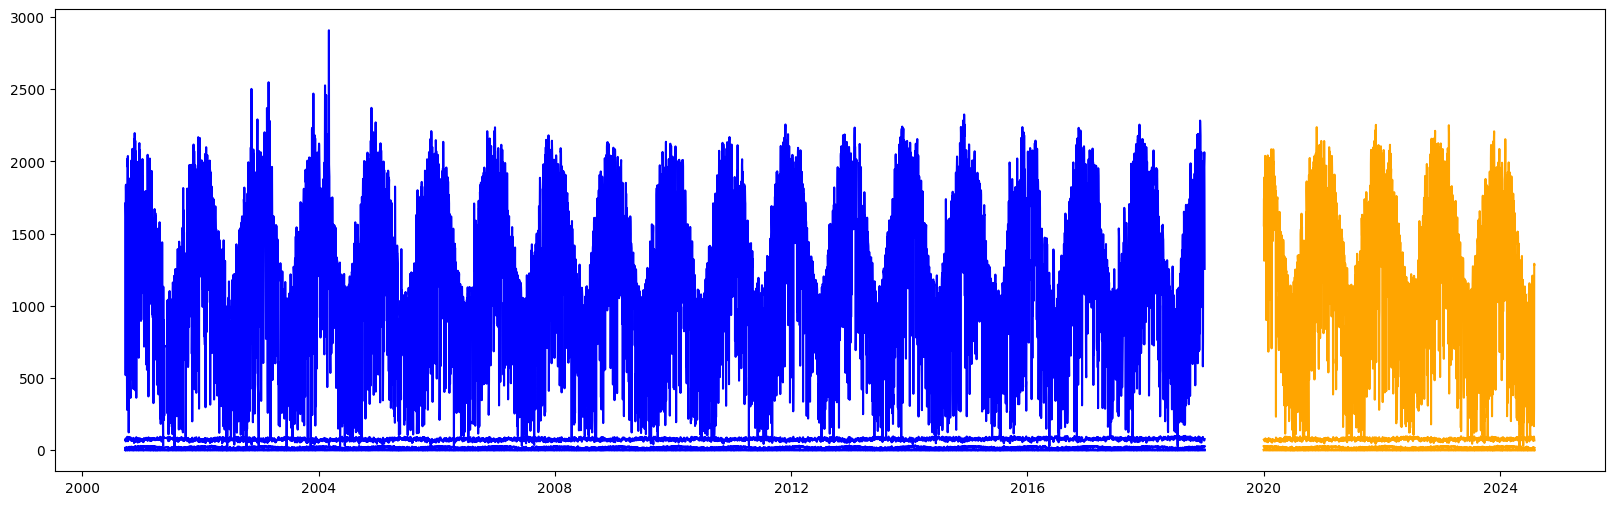

In [6]:
train = by_day[by_day.index <= pd.to_datetime("2020", format="%Y")].dropna()
test = by_day[by_day.index > pd.to_datetime("2020", format="%Y")].dropna()

plt.figure(figsize=(20, 6))
plt.plot(train, color="blue")
plt.plot(test, color="orange")

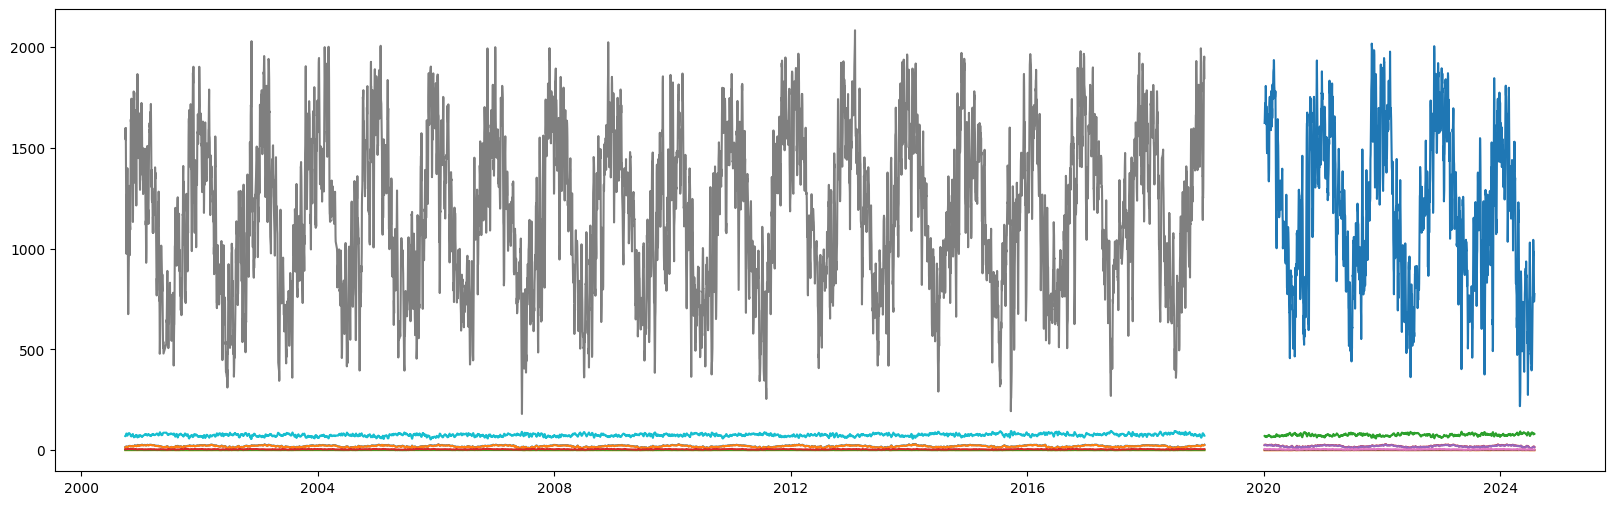

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2000-09-22 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-23 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-24 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-25 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-26 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2018-12-27 11:30:00,1745.060952,0.020238,75.970238,25.133929,23.963095,2.073810,5.911905
2018-12-28 11:30:00,1923.963810,0.000000,73.166667,25.808929,24.569643,2.075595,5.842262
2018-12-29 11:30:00,1944.577143,0.000000,72.035714,26.114286,24.800000,2.015476,5.689286


In [20]:
train_rolling = train.rolling(window=7).mean().copy()
test_rolling = test.rolling(window=7).mean().copy()

plt.figure(figsize=(20, 6))
plt.plot(test_rolling)
plt.plot(train_rolling)
plt.show()
train_rolling

In [17]:
fit_data = pd.DataFrame(
    dict(ds=train_rolling.index, y=train_rolling["global-radiation"])
)
fit_data

from prophet import Prophet

reg = Prophet()
reg.fit(fit_data)

18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing


/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


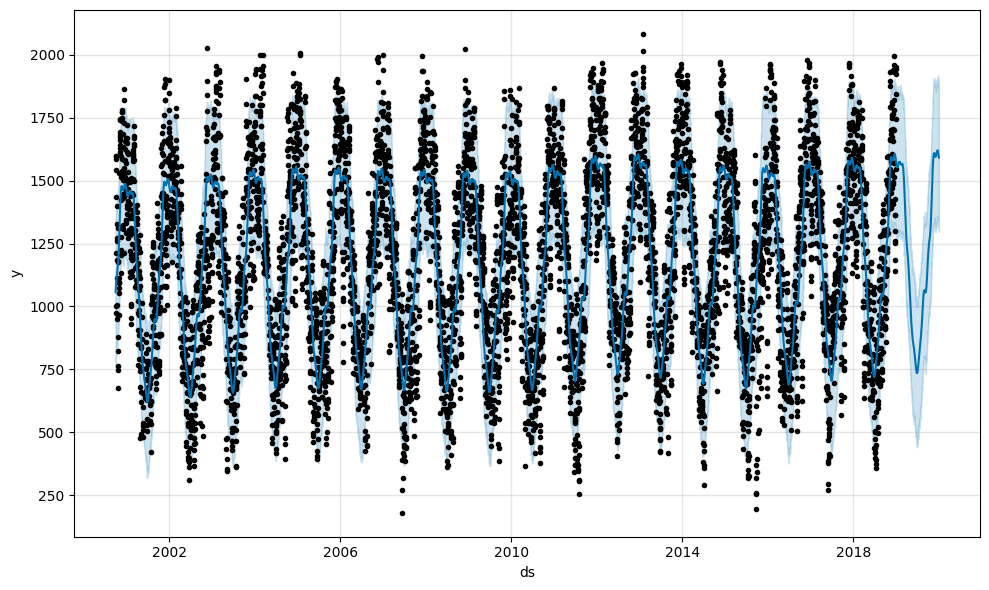

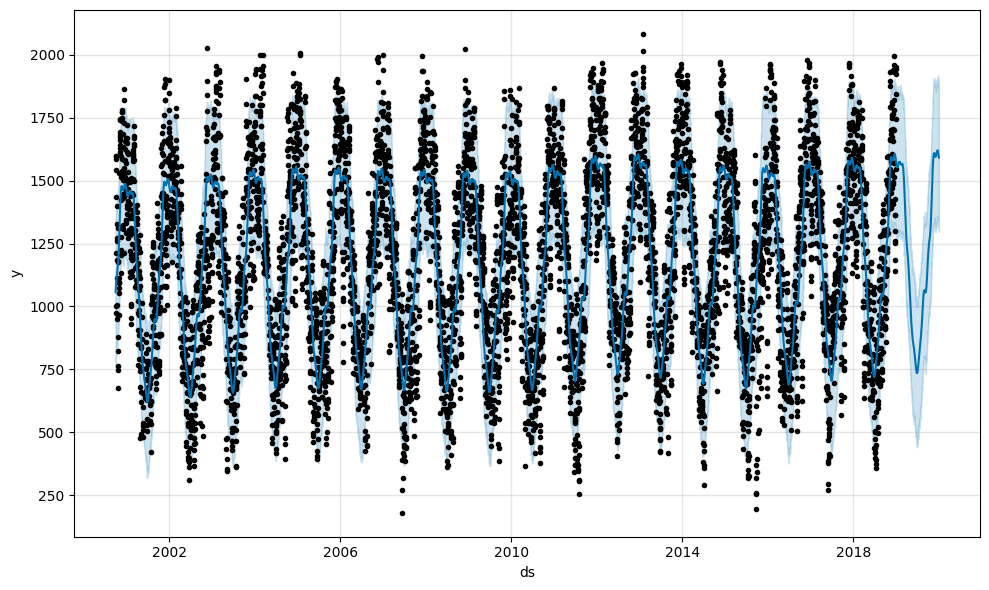

In [27]:
future = reg.make_future_dataframe(periods=365)
forecast = reg.predict(future)

reg.plot(forecast)